# IACV Exercise 5: Transfer Learning

In this exercise, you will again tackle the image classification task, as in exercise 4.
Given an input RGB image with resolution `(32, 32, 3)`, you need to predict which of the 10 input classes it belongs to.
However, unlike in exercise 4, you have access to limited training data in `training.h5`.
In fact, you only have `210` samples per class, which are separated into training, validation, and test sets of ratio `7:1:2` for ease of use.
You can use these three sets of data for your development.

Fortunately, you have access to a pre-trained network which has been trained on large amounts of data to classify 5 out of 10 input classes.
That is, the pre-trained network obtains a classification accuracy of around 95% for 5 of the classes, while the remaining classes are not defined at all.
The pretrained parameters are stored in `ckpt/resnet4five.pt` and the loading process explained below.

Your task is to either adapt this model, or train a new network from scratch which can classify all 10 classes.
Similar to exercise 4, we will use the [PyTorch](https://https://pytorch.org/) deep learning framework in this exercise.

**Evaluation Criteria**

Your algorithm will be evaluated using classification accuracy, which is the proportion of images with the correct predicted label.
The final EvaluationScore is obtained as the classification accuracy over all test samples, over all 10 classes.
The real test data used for evaluation has 1000 images without labels and can be found in `test.h5`

**Rules**

Throughout this project, you are **not allowed to use any other dataset and/or pre-trained model other than the given ones**.
You are allowed to use any other techniques you have learned in the course, including but not limited to
*data augmentation, early stopping, and transfer learning*.

In [3]:
# These two lines ensure that we always import the latest version of a package
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt


import os
import sys
import shutil
from pathlib import Path

import torch
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
iacv_path = 'MyDrive/IACV/ex5' # TODO set this

env_path = Path('/content/drive/') / iacv_path
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(str(env_path))

## Enabeling GPU on CoLab
For this exercise you might want to use a GPU.
Even the small ResNet we provide runs more than 25 times faster on CoLabs free GPU compared to CoLabs CPUs.

In the CoLab menu, go to `Runtime` -> `Change Runtime Type` and select `T4 GPU` as harware accelerator.

Note that this is free! You will not need to pay anything to use this service!

In [5]:
# With PyTorch you can check if a GPU is available as follows:
print(f"Is a CUDA capable GPU available? {torch.cuda.is_available()}")

# Note: CUDA is the platform developed by NVIDIA for their GPUs

Is a CUDA capable GPU available? True


## Mapping from 5 to 10 classes

Define a mapping from 5 to 10 classes because the indices do not match, such as `classes[0]` is `Airplane` while `classes5[0]` is `Cat`

In [29]:
# Mapping from 5 to 10 classes

# Classes for the pretrained dataset
classes5 = ["Cat", "Deer", "Frog", "Ship", "Truck"]

# Actual classes
classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
           "Dog", "Frog", "Horse", "Ship", "Truck"]

# Converting numpy arrays for indexing
classes5 = np.array(classes5)
classes = np.array(classes)

# Mapping from 5 classes to 10 classes for evaluation
map5to10 = [np.where(classes==class_)[0][0] for class_ in classes5]
map5to10 = np.array(map5to10)
print("Mapping array is:", map5to10)

Mapping array is: [3 4 6 8 9]


In [33]:
# Example usage

# Random predictions by 5
preds5 = np.random.randint(5, size=7, dtype=int)
# Predicted classes
print("Actual Predictions:        ", classes5[preds5])

# Wrong mapping from 5 to 10 classes
print("Wrongly-mapped Predictions:", classes[preds5])

# Correct mapping from 5 to 10 classes
print("Correct-mapped Predictions:", classes[map5to10[preds5]])

[2 0 2 1 4 4 2]
Actual Predictions:         ['Frog' 'Cat' 'Frog' 'Deer' 'Truck' 'Truck' 'Frog']
Wrongly-mapped Predictions: ['Bird' 'Airplane' 'Bird' 'Automobile' 'Deer' 'Deer' 'Bird']
Correct-mapped Predictions: ['Frog' 'Cat' 'Frog' 'Deer' 'Truck' 'Truck' 'Frog']


## Create dataloaders

We have implemented the basic data handling.
You might want to check out the file `dataset.py` nonetheless.
In case you want to apply data augmentations during training, etc...


In [8]:
from dataset import get_datasets_from_h5, get_loaders_from_datasets

# Get the datasets
data_path = env_path / 'data'
train_dataset, val_dataset, test_dataset = get_datasets_from_h5(data_path / 'training.h5')

# Construct the dataloaders
batch_size = 24
train_loader, val_loader, test_loader = get_loaders_from_datasets(
    train_dataset, val_dataset, test_dataset, batch_size
)

# Print the sizes of the datasets
print(f"The dataset contains {train_dataset.num_classes} classes.")
print(f"Number of images in each dataset: Training={len(train_dataset)}, ",
      f"Validation={len(val_dataset)}, Test={len(test_dataset)}")


The dataset contains 10 classes.
Number of images in each dataset: Training=1470,  Validation=210, Test=420


## Visualize training images

tensor([1, 7, 2, 9, 2, 8])


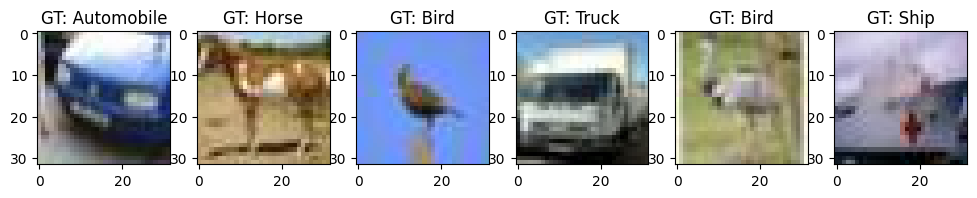

In [37]:
from utils import show_images

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels[:6])
show_images(images[:6], classes[labels[:6]])

## Load pre-trained model

As mentioned before, you have access to parameters of a pre-trained model `resnet4five.pt`, which is a standard ResNet18 model and has been trained to classify images into 5 classes ("Cat", "Deer", "Frog", "Ship", "Truck"), using larger dataset. It achieves accuracy of higher than 90% for these classes.

In [10]:
from model import generate_resnet

# Path to load the model from
load_path = env_path / 'ckpt' / 'resnet4five.pt'

# Device to train on
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the model with 5 output classes
model = generate_resnet(num_classes=5)

# Next we load the pre-trained weights, and set it to the model we created
model.load_state_dict(torch.load(load_path, map_location=device, weights_only=True))

<All keys matched successfully>

Next, we can test the pre-trained model on the dataset.
Check out the file `evaluation.py` to see how the model is used to make a prediction.
A very similar code will be used to create your prediction at the end of this file.

Test accuracy with pretrained model: 0.476


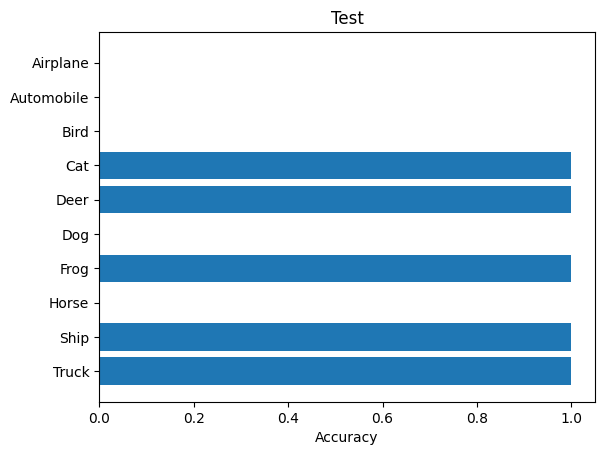

In [11]:
from evaluation import evaluate_model
from utils import show_class_accs

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader, device=device, mapping=map5to10)
print(f"Test accuracy with pretrained model: {test_accuracy:.3f}")

# Classwise accuracies
test_class_accs = evaluate_model(
    model, test_loader, device=device, mapping=map5to10, classwise=True
)

show_class_accs(test_class_accs, classes, title="Test")

As expected, we see the the pre-trained model obtains good performance on the 5 out of 10 classes which it has been trained for. However, it cannot handle the other 5 *unseen* classes, and thus obtains a low overall classification accuracy. Your task is to adapt this pre-trained model such that it obtains better overall classification accuracy than iacvbasline.

In [14]:
state_dict = torch.load(load_path, map_location=device, weights_only=True)
print("Last keys in file:", list(state_dict.keys())[-2:])

Last keys in file: ['linear.weight', 'linear.bias']


## Your Solution

You can write your own implementation here.
You can change the custom functions given according to your needs.

In [38]:
# For convenience reimport all custom functions
from utils import seed_everything
from model import generate_resnet
from dataset import get_datasets_from_h5, get_loaders_from_datasets
from training import train_model
from evaluation import evaluate_model

from torchsummary import summary

 # Give your Legi number as random seed
seed = 25953794
seed_everything(seed)
#take the resnet
model = generate_resnet() #has as output the logits so as a loss is correct to have crossentropy
#load the pretrained params
state_dict = torch.load(load_path, map_location=device, weights_only=True)
keys_to_delete = ['linear.weight', 'linear.bias']
for key in keys_to_delete:
    if key in state_dict:
        del state_dict[key]
        print(f"Removed key: {key}") # Optional: for debugging
# Load the remaining weights using strict=False
model.load_state_dict(state_dict, strict=False)
#make the model work on the GPU
model = model.to(device)
#define a loss
loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#train it on the new classes i have to be aware of the fact that i only need to train and look in the 5 buckets where the resnet is not trained

#batch size is already defined
learning_rate = 0.001    # Learning rate in the optimizer
num_epochs = 7           # Number of passes over the entire dataset
print_every_iters = 100  # Print training loss every X mini-batches
#Main training Loop
training_loss_per_epoch = []
val_loss_per_epoch = []
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_type(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() #note that loss is a tensor containing a graph representing the dependancies between the layers of the nn
    if (i + 1) % print_every_iters == 0:
      print(
                f'[Epoch: {epoch + 1} / {num_epochs},'
                f' Iter: {i + 1:5d} / {len(train_loader)}]'
                f' Training loss: {running_loss / (i + 1):.3f}'
            )
  mean_loss = running_loss / len(train_loader)
  training_loss_per_epoch.append(mean_loss)
  model.eval()

  #see how the model is performing on the validtion set, use it as a referenc eto avoid overfit

  running_loss = 0.0

  for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    with torch.no_grad(): #used whenever I don't want to compute gradients later, in this way we can achieve a better performance
      outputs = model(inputs.to(device))
      loss = loss_type(outputs, labels.to(device))
    running_loss += loss.item()

  mean_loss = running_loss / len(val_loader)
  val_loss_per_epoch.append(mean_loss)

  print(
        f'[Epoch: {epoch + 1} / {num_epochs}]'
        f' Validation loss: {mean_loss:.3f}'
    )

print('Finished Training')



Removed key: linear.weight
Removed key: linear.bias
[Epoch: 1 / 7] Validation loss: 1.393
[Epoch: 2 / 7] Validation loss: 0.950
[Epoch: 3 / 7] Validation loss: 0.827
[Epoch: 4 / 7] Validation loss: 0.747
[Epoch: 5 / 7] Validation loss: 0.725
[Epoch: 6 / 7] Validation loss: 0.708
[Epoch: 7 / 7] Validation loss: 0.666
Finished Training


Test accuracy with pretrained model: 0.102


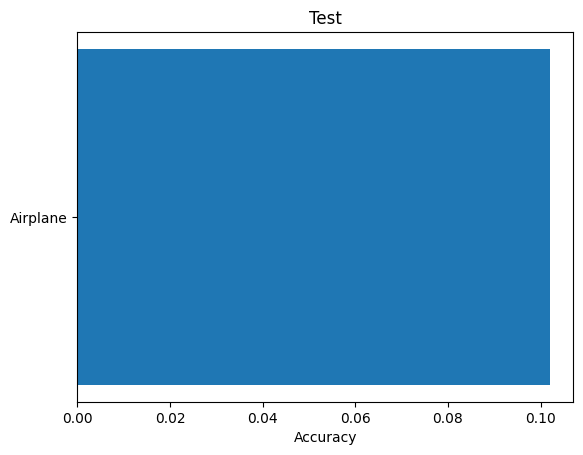

In [39]:
from evaluation import evaluate_model
from utils import show_class_accs

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader, device=device)
print(f"Test accuracy with pretrained model: {test_accuracy:.3f}")

# Classwise accuracies
test_class_accs = evaluate_model(
    model, test_loader, device=device, classwise=True
)

show_class_accs(test_class_accs, classes, title="Test")

## Generating the final submission

When you are happy with your network, you can run the next cell to generate your network predictions on the test set, which will be stored in the submission directory on your Google Drive.
Download the submission folder (without renaming) as a zip, and upload it to the evaluation server to obtain the scores on the test set.

In [40]:
from dataset import get_test_loader

test_h5_path = env_path / 'data' / 'test.h5'

submission_path = env_path / 'submission'
submission_path.mkdir(exist_ok=True)

# Choose device to run inference
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load test dataset and dataloader
test_loader = get_test_loader(test_h5_path)

# Predictions to store
predictions = list()

# Set to evaluation mode
model.eval()

# Iterate over the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Get the predictions
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        predictions.extend(preds.tolist())

# Save the outputs (do not change the name)
np.savetxt(submission_path / 'labels.csv', predictions, fmt="%d")

# Save the relevant files (do not change the name)
shutil.copyfile(env_path / 'model.py', submission_path / 'model.py')
shutil.copyfile(env_path / 'dataset.py', submission_path / 'dataset.py')
shutil.copyfile(env_path / 'training.py', submission_path / 'training.py')
shutil.copyfile(env_path / 'handout.ipynb', submission_path / 'handout.ipynb')

PosixPath('/content/drive/MyDrive/IACV/ex5/submission/handout.ipynb')